In [1]:
import pandas as pd
import numpy as np

import black
import jupyter_black

jupyter_black.load(
    lab=False,
    line_length=79,
    verbosity="DEBUG",
    target_version=black.TargetVersion.PY310,
)

from tqdm.auto import tqdm

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import f1_score, classification_report

import xgboost as xgb
import random
import umap
import matplotlib.pyplot as plt
import time 

DEBUG:jupyter_black:config: {'line_length': 79, 'target_versions': {<TargetVersion.PY310: 10>}}


<IPython.core.display.Javascript object>

/dgx1nas1/storage/data/sam/.conda/envs/varchamp/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_dir = "/dgx1nas1/storage/data/sam/processed"
result_dir = "/dgx1nas1/storage/data/sam/results/Run2"
feature_type = "_normalized_feature_selected"
batch = "2023_05_30_B1A1R1"

In [3]:
sc_profiles_path = (
    f"{data_dir}/{batch}{feature_type}_nonull.parquet"
)

sc_profiles = pd.read_parquet(sc_profiles_path)
print(sc_profiles.shape)

(1949626, 1057)


In [420]:
sc_profiles.groupby(['Metadata_Variant'])['Metadata_Plate'].unique()[20]

array(['2023-05-30_B1A1R1_P1T1', '2023-05-25_B1A1R1_P1T3',
       '2023-05-25_B1A1R1_P1T4', '2023-05-24_B1A1R1_P1T2'], dtype=object)

In [133]:
var_gene = list(sc_profiles[sc_profiles["Metadata_node_type"] == "allele"]['Metadata_Gene'].unique())
var_num = sc_profiles[sc_profiles["Metadata_node_type"] == "allele"]['Metadata_Variant'].unique().size

In [134]:
ref_gene = list(sc_profiles[sc_profiles["Metadata_node_type"] == "disease_wt"]['Metadata_Gene'].unique())
com_gene = list(set(var_gene)&set(ref_gene))

In [140]:
print(f'This batch contains {var_num} variants from {len(var_gene)} genes, and {len(ref_gene)} references. The overlap between ref and var is {len(com_gene)}.')

This batch contains 987 variants from 166 genes, and 295 references. The overlap between ref and var is 140.


In [141]:
sc_profiles_filtered = sc_profiles[sc_profiles['Metadata_Gene'].isin(com_gene)]
var_num_filtered = sc_profiles_filtered[sc_profiles_filtered["Metadata_node_type"] == "allele"]['Metadata_Variant'].unique().size

In [145]:
print(f'After filtering, there are {var_num_filtered} variants left.')

After filtering, there are 803 variants left.


In [170]:
controls = sc_profiles[sc_profiles["Metadata_control"].astype('bool')]

In [253]:
sc_profiles_filtered[sc_profiles_filtered['Metadata_Variant']=='STXBP1']

,Metadata_Plate,Metadata_Well,Metadata_Batch,Metadata_allele_set,Metadata_Symbol,Metadata_entry_plate,Metadata_entry_well,Metadata_entry_numb,Metadata_dest_plate,Metadata_dest_well,...,Nuclei_Texture_SumVariance_DNA_10_03_256,Nuclei_Texture_SumVariance_DNA_20_00_256,Nuclei_Texture_SumVariance_DNA_20_01_256,Nuclei_Texture_SumVariance_DNA_20_02_256,Nuclei_Texture_SumVariance_DNA_20_03_256,Nuclei_Texture_SumVariance_Mito_20_00_256,Nuclei_Texture_SumVariance_Mito_20_01_256,Nuclei_Texture_SumVariance_Mito_20_02_256,Nuclei_Texture_SumVariance_Mito_20_03_256,Nuclei_Texture_SumVariance_Mito_5_01_256
352144,2023-05-30_B1A1R1_P4T1,K21,1.0,1.0,STXBP1,DisWTGDEh03,F03,22.0,FVrry_P04_Q01,F11,...,8.696047,-1.014831,-0.738127,-1.012779,-0.748133,-0.674491,-0.674491,-0.674491,-0.674491,0.950143
352145,2023-05-30_B1A1R1_P4T1,K21,1.0,1.0,STXBP1,DisWTGDEh03,F03,22.0,FVrry_P04_Q01,F11,...,-0.206967,-0.046987,0.104778,-0.034766,0.736817,8.868063,10.051537,10.421572,7.867199,16.687074
352146,2023-05-30_B1A1R1_P4T1,K21,1.0,1.0,STXBP1,DisWTGDEh03,F03,22.0,FVrry_P04_Q01,F11,...,9.803785,9.734698,7.627926,6.541678,11.278974,10.101920,13.720130,16.325206,16.019790,17.362655
352147,2023-05-30_B1A1R1_P4T1,K21,1.0,1.0,STXBP1,DisWTGDEh03,F03,22.0,FVrry_P04_Q01,F11,...,8.560827,7.375458,3.907027,8.119420,0.132152,0.983443,0.295344,1.813620,-0.466436,0.750287
352148,2023-05-30_B1A1R1_P4T1,K21,1.0,1.0,STXBP1,DisWTGDEh03,F03,22.0,FVrry_P04_Q01,F11,...,376.546073,-1.014831,-0.738127,-1.012779,-0.748133,-0.674491,-0.674491,-0.674491,-0.674491,7.036529
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1921493,2023-05-30_B1A1R1_P4T2,K21,1.0,1.0,STXBP1,DisWTGDEh03,F03,22.0,FVrry_P04_Q01,F11,...,-0.234175,-0.129171,0.308626,0.652866,0.135375,0.559819,1.465817,5.412926,0.994129,2.717605
1921547,2023-05-30_B1A1R1_P4T2,K21,1.0,1.0,STXBP1,DisWTGDEh03,F03,22.0,FVrry_P04_Q01,F11,...,-0.321677,0.062113,0.141152,-0.097016,0.163475,-0.403511,0.378718,-0.218588,-0.299243,-0.643952
1921651,2023-05-30_B1A1R1_P4T2,K21,1.0,1.0,STXBP1,DisWTGDEh03,F03,22.0,FVrry_P04_Q01,F11,...,-0.149910,-0.988595,-0.674491,-0.986553,-0.674491,-0.674491,-0.674491,-0.674491,-0.674491,0.952386
1921652,2023-05-30_B1A1R1_P4T2,K21,1.0,1.0,STXBP1,DisWTGDEh03,F03,22.0,FVrry_P04_Q01,F11,...,-0.386193,-0.207869,0.151130,-0.233586,0.199747,0.143668,-0.269417,0.018279,-0.040913,-0.272485


In [165]:
com, list1_uniq, list2_uniq = create_venn(ref_gene, var_gene)

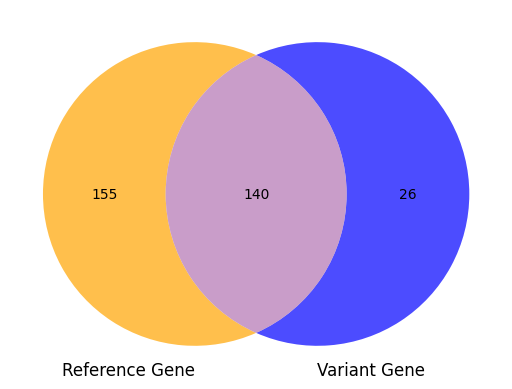

In [205]:
# depict venn diagram 
out = venn2_unweighted(subsets = (list1_uniq, list2_uniq, com), 
                 set_labels = ('Reference Gene',  
                               'Variant Gene'), 
                 set_colors=("orange", 
                             "blue"),alpha=0.7) 

plt.show()

In [346]:
from itertools import chain, combinations, pairwise, permutations


In [339]:
test_list = ['A01', 'B01', 'A02', 'B02']

In [356]:
for subset in combinations(test_list, r=2):
    print(subset)

('A01', 'B01')
('A01', 'A02')
('A01', 'B02')
('B01', 'A02')
('B01', 'B02')
('A02', 'B02')


In [362]:
random.choices([ x for x in combinations(test_list, r=2)], k=4)

[('B01', 'B02'), ('A01', 'B01'), ('A01', 'A02'), ('B01', 'B02')]

In [6]:
sc_profiles.drop(np.where(sc_profiles['Metadata_Batch'].isna())[0], axis=0, inplace=True)
sc_profiles.reset_index(drop=True, inplace=True)

In [7]:
r,c = np.where(sc_profiles.isna())
feat, count = np.unique(c, return_counts = True)

feat_to_remove = []
row_to_remove = []
cell_threshold = 100

for i in range(len(feat)):
    feat_name = sc_profiles.columns[feat[i]]
    if feat_name.startswith('Metadata_'): continue
        
    if count[i]>cell_threshold:
        feat_to_remove.append(feat_name)
    else:
        row_to_remove = row_to_remove + np.where(sc_profiles[feat_name].isna())[0].tolist()
        row_to_remove = list(set(row_to_remove))

In [8]:
# drop features with more than 100 nan values, otherwise drop nan rows
sc_profiles.drop(feat_to_remove, axis=1, inplace=True)
sc_profiles.drop(row_to_remove, axis=0, inplace=True)
sc_profiles.reset_index(drop=True, inplace=True)
print(f'Removed {len(feat_to_remove)} nan features and {len(row_to_remove)} nan rows.')

Removed 94 nan features and 50 nan rows.


In [9]:
feat_col = [i for i in sc_profiles.columns if "Metadata_" not in i]
assert ~np.isnan(sc_profiles[feat_col]).any().any(), "Dataframe contain NaN features." 
assert np.isfinite(sc_profiles[feat_col]).all().all(), "Dataframe contain infinite feature values."

In [10]:
# sc_profiles.drop(["ObjectNumber", "ObjectNumber_Cells"], axis=1, inplace=True)
meta_col = [i for i in sc_profiles.columns if "Metadata_" in i]
feat_col = [i for i in sc_profiles.columns if "Metadata_" not in i]

In [11]:
# Include only GFP features for protein channel 
feat_cols_protein = [
    i
    for i in feat_col
    if ("GFP" in i)
    and ("DNA" not in i)
    and ("AGP" not in i)
    and ("Mito" not in i)
]
# Select non-protein channel features, where GFP does not exist in feat_cols
feat_cols_non_protein = [i for i in feat_col if "GFP" not in i]

In [12]:
use_protein_feat = True

In [13]:
if use_protein_feat:
    feature_columns = feat_cols_protein
    protein_suffix = "protein"
else:
    feature_columns = feat_cols_non_protein
    protein_suffix = "non_protein"

In [14]:
print(np.isnan(sc_profiles[feat_col]).any().any())
print(np.isfinite(sc_profiles[feat_col]).all().all())

False
True


### Variant against Reference Classification

In [4]:
experiments = sc_profiles[~sc_profiles["Metadata_control"].astype('bool')].reset_index(drop=True)
gene_group = experiments.groupby("Metadata_Gene").groups

In [1]:
sc_profiles['Metadata_node_type'].unique()

NameError: name 'sc_profiles' is not defined

In [ ]:
f1score_macro_list = []
f1score_macro_shuff_list = []
gene_list = []
pair_list = []
feat_list = []

for gene_key in tqdm(gene_group.keys()):
    gene_profiles = experiments.loc[gene_group[gene_key]]
    print(gene_profiles.Metadata_node_type.unique())
    continue
    # Ensure this gene has both reference and variants
    if gene_profiles.Metadata_node_type.unique().size != 2:
        continue
    print('start classification for gene {gene_key}')
    # All wildtype cells for the gene
    ref_profiles = gene_profiles[
        gene_profiles["Metadata_node_type"] == "disease_wt"
    ].reset_index(drop=True)

    var_group = (
        gene_profiles[gene_profiles["Metadata_node_type"] == "allele"]
        .groupby("Metadata_Variant")
        .groups
    )

    for var_key in var_group.keys():
        # All cells from the specific variant
        var_profiles = gene_profiles.loc[var_group[var_key]]
        ref_profiles["Label"] = 1
        var_profiles["Label"] = 0
        all_profiles = pd.concat(
            [ref_profiles, var_profiles], ignore_index=True
        )
        X, y = all_profiles[feature_columns], all_profiles[["Label"]]

        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, random_state=1
        )

        # Create shuffled train labels
        y_train_shuff = y_train.copy()
        y_train_shuff["Label"] = np.random.permutation(y_train.values)

        # Model train and predict
        model = xgb.XGBClassifier().fit(X_train, y_train)
        preds = model.predict(X_test)

        # Store feature importance
        feat_importances = pd.Series(
            model.feature_importances_, index=X_train.columns
        )
        feat_list.append(feat_importances)

        #         # Model trained with shuffled label data (null)
        #         model_shuff = xgb.XGBClassifier().fit(X_train, y_train_shuff)
        #         preds_shuff = model_shuff.predict(X_test)

        # Evaluate with metrics
        f1score_macro = f1_score(y_test, preds, average="macro")
        #         f1score_macro_shuff = f1_score(y_test, preds_shuff, average="macro")

        f1score_macro_list.append(f1score_macro)
        #         f1score_macro_shuff_list.append(f1score_macro_shuff)
        gene_list.append(gene_key)
        pair_list.append(var_key)
        break

In [109]:
df_feat_one = pd.DataFrame({"Gene": gene_list, "Variant": pair_list})
df_feat_two = pd.DataFrame(feat_list)
df_feat = pd.concat([df_feat_one, df_feat_two], axis=1)

In [110]:
df_feat.to_csv(
    f"{data_dir}{protein_suffix}_var_feat_importance{feature_type}.csv",
    index=False,
)

In [111]:
len(f1score_macro_list)

153

In [112]:
result_csv = pd.DataFrame(
    {
        "Gene": gene_list,
        "Variant": pair_list,
        "F1_Score": f1score_macro_list
        # "F1_Score_shuffled": f1score_macro_shuff_list,
    }
)
result_csv.to_csv(
    f"{data_dir}{protein_suffix}_variant_prediction{feature_type}.csv",
    index=False,
)

In [113]:
result_csv

,Gene,Variant,F1_Score
0,BRD-A07207424-001-15-9,BRD-K49223707-001-01-0,0.882517
1,BRD-A09722536-002-18-0,BRD-K97010173-001-04-1,0.915517
2,BRD-A10188456-001-04-9,BRD-K48830578-001-01-9,0.940472
3,BRD-A15397381-001-02-5,BRD-A74391928-051-04-9,0.874293
4,BRD-A18763547-300-05-5,BRD-A31564021-001-01-8,0.982950
...,...,...,...
148,BRD-K91825936-001-03-9,BRD-A48180038-003-24-3,0.932127
149,BRD-K93632104-001-17-2,BRD-K26521938-001-07-2,0.949310
150,BRD-K93788137-001-05-9,BRD-K47049295-300-03-1,0.940974
151,BRD-K97091514-001-11-4,BRD-A82396632-008-28-2,0.856085


### Controls - Well Location Classification

In [18]:
controls = sc_profiles[sc_profiles["Metadata_control"].astype('bool')]

control_group = controls.groupby("Metadata_Sample_Unique").groups

In [19]:
controls['Plate_Well'] = controls['Metadata_Plate'] + '_' + controls['Metadata_Well']
controls['Plate_Well'].unique().size

604

In [ ]:
f1score_macro_list = []
gene_list = []
pair_list = []
f1score_macro_shuff_list = []
feat_list = []

for gene_key in tqdm(control_group.keys()):
    gene_profiles = controls.loc[control_group[gene_key]]

    # Skip controls with no replicates
    if gene_profiles.Metadata_Well.unique().size < 2:
        continue
    # All controls cells of the same treatment
    well_group = gene_profiles.groupby("Metadata_Well").groups
    well_list = list(well_group.keys())
    for i in range(len(well_list) - 1):
        # All cells from the specific variant
        well_one = gene_profiles.loc[well_group[well_list[i]]]
        well_one["Label"] = 1

        for j in range(i + 1, len(well_list)):
            well_two = gene_profiles.loc[well_group[well_list[j]]]
            well_two["Label"] = 0

            all_profiles = pd.concat([well_one, well_two], ignore_index=True)
            X, y = all_profiles[feature_columns], all_profiles[["Label"]]

            # Split the data
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.3, random_state=1
            )

            # Create shuffled train labels
            y_train_shuff = y_train.copy()
            y_train_shuff["Label"] = np.random.permutation(y_train.values)

            # Model train and predict
            model = xgb.XGBClassifier().fit(X_train, y_train)
            preds = model.predict(X_test)

            # Store feature importance
            feat_importances = pd.Series(
                model.feature_importances_, index=X_train.columns
            )
            feat_list.append(feat_importances)

            #             model_shuff = xgb.XGBClassifier().fit(X_train, y_train_shuff)
            #             preds_shuff = model_shuff.predict(X_test)

            # Evaluate with metrics
            f1score_macro = f1_score(y_test, preds, average="macro")
            #             f1score_macro_shuff = f1_score(y_test, preds_shuff, average="macro")

            #             f1score_macro_shuff_list.append(f1score_macro_shuff)
            f1score_macro_list.append(f1score_macro)
            gene_list.append(gene_key)
            pair_list.append(well_list[i] + "_" + well_list[j])

In [117]:
ctrl_feat_one = pd.DataFrame({"Gene": gene_list, "Variant": pair_list})
ctrl_feat_two = pd.DataFrame(feat_list)
ctrl_feat = pd.concat([ctrl_feat_one, ctrl_feat_two], axis=1)

In [118]:
ctrl_feat.to_csv(
    f"{data_dir}{protein_suffix}_ctrl_feat_importance{feature_type}.csv",
    index=False,
)

In [119]:
control_csv = pd.DataFrame(
    {
        "Treatment": gene_list,
        "Well_Pair": pair_list,
        "F1_Score": f1score_macro_list
        # "F1_Score_shuffled": f1score_macro_shuff_list,
    }
)
control_csv.to_csv(
    f"{data_dir}{protein_suffix}_control_prediction{feature_type}.csv",
    index=False,
)

### Visualization

In [386]:
import seaborn as sb
import matplotlib.pyplot as plt

In [445]:
result_dir = "/dgx1nas1/storage/data/sam/results/Run7"


In [495]:
df_protein_ctrl = pd.read_csv(
    f"{result_dir}/{batch}_protein_control_f1score{feature_type}.csv"
)
df_protein_var = pd.read_csv(
    f"{result_dir}/{batch}_protein_f1score{feature_type}.csv"
)

df_non_protein_ctrl = pd.read_csv(
    f"{result_dir}/{batch}_non_protein_control_f1score{feature_type}.csv"
)
df_non_protein_var = pd.read_csv(
    f"{result_dir}/{batch}_non_protein_f1score{feature_type}.csv"
)

In [496]:
exclude_neg_pro = False

neg_con = ["527 MAPK9", "527 PRKACB", "527 RHEB", "527 SLIRP"]
if exclude_neg_pro:
    df_protein_ctrl = df_protein_ctrl[df_protein_ctrl["Gene"].isin(neg_con)]

In [506]:
def comput_p_values(null_dists, f1_scores):
    p_values = np.empty(len(f1_scores), dtype=np.float32)
    null_dists = np.sort(null_dists)
    for i, score in enumerate(f1_scores):
        # Reverse to get from hi to low
        null_size = null_dists.shape[0]
        num =  null_size - np.searchsorted(null_dists, score)
        p_values[i] = (num + 1) / (null_size + 1)
    return p_values

In [554]:
lambda_val = np.percentile(np.sort(10**-df_protein_var_avg['-logp'].to_numpy()), 50)

In [555]:
# def calculate_fpr(fpos, pos, all):
#     p_val = np.exp(-fpos)
#     return p_val /(pos/len(all) + p_val)

# def calculate_fpr(fpos, pos, all):
#     p_val = from_neg_log(fpos)
#     return p_val /(pos/len(all) + p_val)
    
def to_neg_log(val):
    return -np.log10(val)
    
def from_neg_log(val):
    return 10**(-val)
    
def calculate_fpr(fpos, pos, all):
    p_val = from_neg_log(fpos)
    return p_val * (0.5/1-lambda_val) * len(all) /pos
    
def count_above(values, threshold):
    return (values > threshold).sum()
    

def search_p_thresh(neg_p_values, null_dists, fpr_bound=0.05, neg_p_minimum=to_neg_log(0.05)):
    neg_p_values_sorted = np.sort(neg_p_values)
    idx = np.searchsorted(neg_p_values_sorted, neg_p_minimum)
    fpr_min = calculate_fpr(neg_p_minimum, 
                            count_above(neg_p_values, neg_p_minimum),
                            neg_p_values
                           )
    # idx = 0
    # fpr_min = 1
    neg_p_thresh_best = neg_p_minimum
    
    while idx < len(neg_p_values_sorted)-1:
        neg_p_thresh = neg_p_values_sorted[idx]
        num_above = count_above(neg_p_values, neg_p_thresh)
        fpr = calculate_fpr(neg_p_thresh, num_above, neg_p_values)
        
        if fpr <= fpr_bound:
            return neg_p_thresh, num_above, fpr
        else:
            idx += 1
            if fpr < fpr_min:
                print(f'p-value: {from_neg_log(neg_p_thresh)}, {num_above}, {fpr}')
                fpr_min = fpr
                neg_p_thresh_best = neg_p_thresh
                
    neg_p_thresh = neg_p_thresh_best     
    num_above = count_above(neg_p_values, neg_p_thresh)
    fpr = calculate_fpr(neg_p_thresh, num_above, neg_p_values)
    
    return neg_p_thresh, num_above, fpr


In [522]:
p_value = comput_p_values(df_protein_ctrl['F1_Score'].to_numpy(), df_protein_var['F1_Score'].to_numpy())
df_protein_var['p-value'] = p_value
df_protein_var['-logp'] = df_protein_var['p-value'].apply(lambda x: to_neg_log(x))

In [523]:
df_protein_var_avg = df_protein_var.groupby(['Gene', 'Variant']).agg({'F1_Score':np.mean, 'p-value':np.mean, '-logp':np.mean}).reset_index()

In [634]:
fdr = 0.35
df_benhoch = df_protein_var_avg.sort_values('-logp', ascending=False).reset_index(drop=True)
df_benhoch['rank'] = df_benhoch.index + 1
df_benhoch['p_value'] = df_benhoch['-logp'].apply(lambda x: from_neg_log(x))
df_benhoch['(I/M)Q'] = df_benhoch['rank']*fdr/df_benhoch.shape[0]

In [635]:
df_benhoch

,Gene,Variant,F1_Score,p-value,-logp,rank,p_value,(I/M)Q
0,CDC73,CDC73 Met1Ile,0.995712,0.002331,2.632457,1,0.002331,0.000436
1,AGXT,AGXT Ile279Met,0.995387,0.002331,2.632457,2,0.002331,0.000873
2,BCL10,BCL10 Leu8Leu,0.993635,0.002914,2.557200,3,0.002772,0.001309
3,BAG3,BAG3 Arg258Trp,0.986988,0.003497,2.481942,4,0.003297,0.001746
4,CHN1,CHN1 Pro252Ser,0.987106,0.004662,2.457715,5,0.003486,0.002182
...,...,...,...,...,...,...,...,...
797,MVK,MVK Leu41Pro,0.362743,0.886946,0.054855,798,0.881344,0.348254
798,UBQLN2,UBQLN2 Pro509Ser,0.372310,0.891608,0.051652,799,0.887867,0.348691
799,THAP1,THAP1 Lys24Glu,0.326747,0.918415,0.040225,800,0.911538,0.349127
800,MLH1,MLH1 Val716Met,0.333591,0.946970,0.023874,801,0.946511,0.349564


In [637]:
for i in range(802):
    index = 801 - i
    p_val = df_benhoch.loc[index, 'p_value']
    crit_val = df_benhoch.loc[index, '(I/M)Q']
    rank_val = df_benhoch.loc[index, 'rank']
    if p_val < crit_val:
        print(f'p_threshold: {p_val}, rank: {rank_val}')
        
        break

p_threshold: 0.12035332606799712, rank: 276


In [556]:
p_thresh, num_above, fpr = search_p_thresh(df_protein_var_avg['-logp'].to_numpy(), df_protein_ctrl['F1_Score'].to_numpy())
print(f'FINAL: -log10p: {p_thresh}, p: {from_neg_log(p_thresh)}, #hit: {num_above}, fpr: {fpr}')

FINAL: -log10p: 1.3010299956639813, p: 0.049999999999999996, #hit: 99, fpr: 0.1254194414523871


In [534]:
0.05*0.5*802/99

0.20252525252525252

In [439]:
f1_thresh_from_p = df_protein_var_avg[df_protein_var_avg['-logp']>p_thresh]['F1_Score'].min()

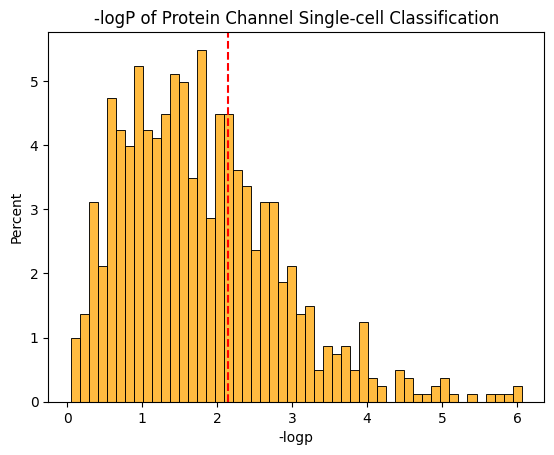

In [487]:
plt.figure()
sb.histplot(
    data=df_protein_var_avg,
    x="-logp",
    bins=50,
    stat="percent",
    color='orange'
)
plt.axvline(p_thresh, color='red', linestyle='--')
plt.title("-logP of Protein Channel Single-cell Classification")
plt.show()

In [394]:
df_protein_ctrl.drop(['Plate'], axis=1,inplace=True)
df_non_protein_ctrl.drop(['Plate'], axis=1,inplace=True)

In [367]:
df_protein_ctrl['platemap'] = df_protein_ctrl['Plate'].apply(lambda x: x.split('_')[-1][0:2])
df_non_protein_ctrl['platemap'] = df_non_protein_ctrl['Plate'].apply(lambda x: x.split('_')[-1][0:2])

# df_protein_ctrl['Well_Pair'] = df_protein_ctrl['Well_Pair'].apply(lambda x: '_'.join(x.split('_')[3:5]))

In [97]:
take_median = False 

if take_median:
# Take median of each variant
    df_protein_var = df_protein_var.groupby(['Gene', 'Variant']).agg({'F1_Score':np.median}).reset_index()
    df_non_protein_var = df_non_protein_var.groupby(['Gene', 'Variant']).agg({'F1_Score':np.median}).reset_index()
    df_protein_ctrl = df_protein_ctrl.groupby(['Treatment', 'platemap', 'Well_Pair']).agg({'F1_Score':np.median}).reset_index()
    df_non_protein_ctrl = df_non_protein_ctrl.groupby(['Treatment', 'platemap', 'Well_Pair']).agg({'F1_Score':np.median}).reset_index()
    df_protein_ctrl.drop('platemap', axis=1, inplace=True)
    df_non_protein_ctrl.drop('platemap', axis=1, inplace=True)

In [395]:
df_protein_ctrl = df_protein_ctrl.set_axis(
    ["Gene", "Variant", "F1_Score"], axis=1
)
df_non_protein_ctrl = df_non_protein_ctrl.set_axis(
    ["Gene", "Variant", "F1_Score"], axis=1
)

df_protein_ctrl["Type"] = "Control"
df_non_protein_ctrl["Type"] = "Control"

df_protein_var["Type"] = "Allele"
df_non_protein_var["Type"] = "Allele"

upsample_fac = df_protein_var.shape[0]//df_protein_ctrl.shape[0]

# if take_median:
#     protein_plot_csv = pd.concat(
#     [df_protein_ctrl, df_protein_var]
# ).reset_index(drop=True)
#     non_protein_plot_csv = pd.concat(
#         [df_non_protein_ctrl, df_non_protein_var]
#     ).reset_index(drop=True)
# else:

protein_plot_csv = pd.concat(
    [pd.concat([df_protein_ctrl]*upsample_fac), df_protein_var]
).reset_index(drop=True)
non_protein_plot_csv = pd.concat(
    [pd.concat([df_non_protein_ctrl]*upsample_fac), df_non_protein_var]
).reset_index(drop=True)

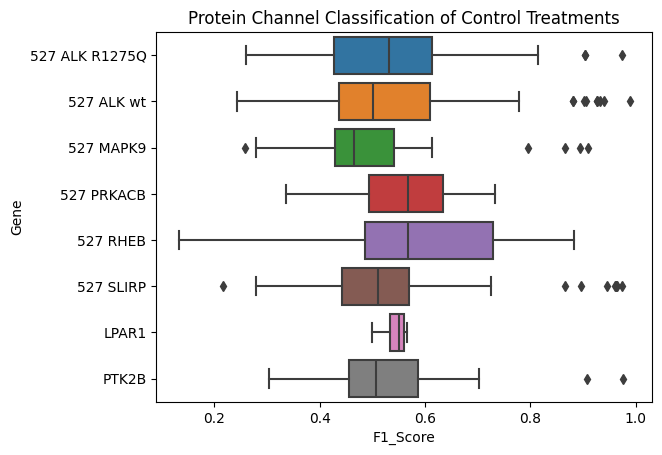

In [396]:
plt.figure()
sb.boxplot(data=df_protein_ctrl, x="F1_Score", y="Gene")
plt.title("Protein Channel Classification of Control Treatments")
plt.show()

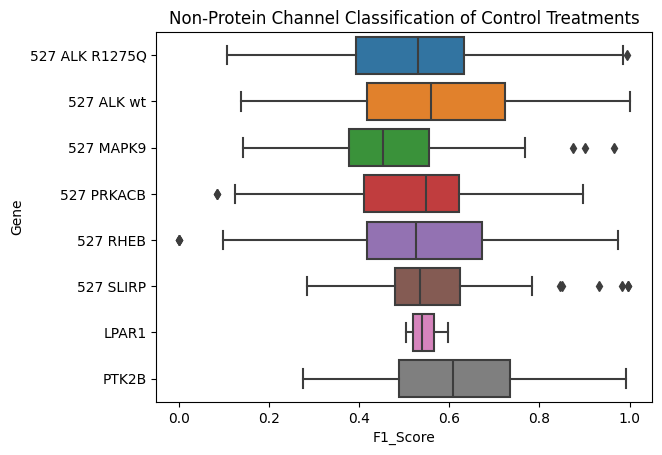

In [397]:
sb.boxplot(data=df_non_protein_ctrl, x="F1_Score", y="Gene")
plt.title("Non-Protein Channel Classification of Control Treatments")
plt.show()

In [414]:
thresh = 95
print(f'Total number of variant pairs: {df_protein_var.shape[0]}')
print(f'Total number of control well pairs: {df_protein_ctrl.shape[0]}')

thresh_protein = np.percentile(np.array(df_protein_ctrl["F1_Score"]), thresh)
thresh_nonprotein = np.percentile(
    np.array(df_non_protein_ctrl["F1_Score"]), thresh
)

print(f"{thresh} percentil of protein control: {thresh_protein}")
print(f"{thresh} percentil of non-protein control: {thresh_nonprotein}")

propass = np.where(df_protein_var["F1_Score"] > thresh_protein)[0].size
nonpropass = np.where(df_non_protein_var["F1_Score"] > thresh_nonprotein)[
    0
].size

print(f"Number of variants passed threshold (protein): {propass}")
print(f"Number of variants passed threshold (non-protein): {nonpropass}")

Total number of variant pairs: 3208
Total number of control well pairs: 428
95 percentil of protein control: 0.8817399404776739
95 percentil of non-protein control: 0.9231102437023008
Number of variants passed threshold (protein): 440
Number of variants passed threshold (non-protein): 599


In [442]:
df_protein_var.iloc[np.where(df_protein_var["F1_Score"] > thresh_protein)].Variant.unique().size

187

In [443]:
df_non_protein_var.iloc[np.where(df_non_protein_var["F1_Score"] > thresh_nonprotein)].Variant.unique().size

304

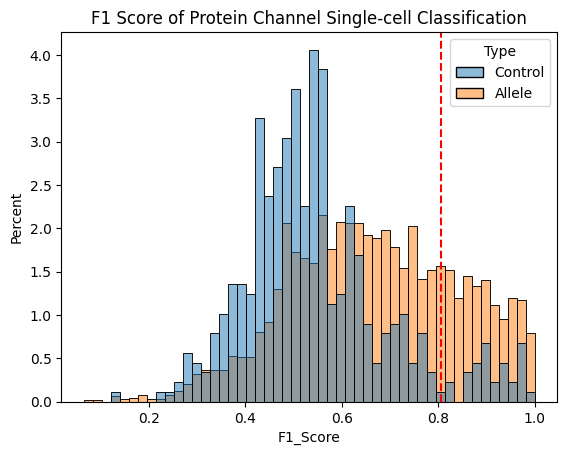

In [440]:
plt.figure()
sb.histplot(
    data=protein_plot_csv,
    x="F1_Score",
    hue="Type",
    bins=50,
    stat="percent",
)
plt.axvline(f1_thresh_from_p, color='red', linestyle='--')
plt.title("F1 Score of Protein Channel Single-cell Classification")
plt.show()

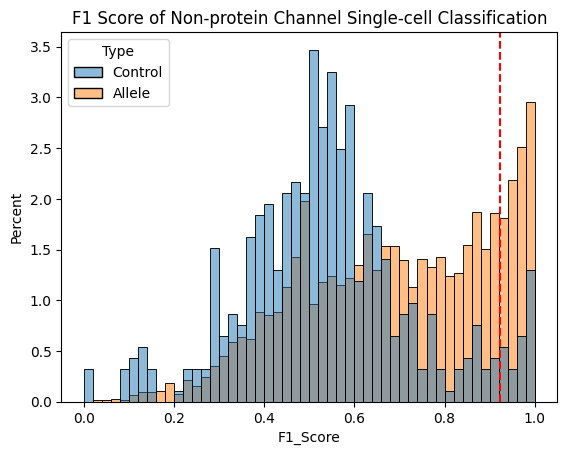

In [416]:
sb.histplot(
    data=non_protein_plot_csv,
    x="F1_Score",
    hue="Type",
    bins=50,
    stat="percent",
)
plt.axvline(thresh_nonprotein, color='red', linestyle='--')
plt.title("F1 Score of Non-protein Channel Single-cell Classification")

plt.show()

In [196]:
# sb.histplot(
#     data=plot_csv, x="F1_Score_shuffled", hue="Type", binrange=(0, 1.0)
# )
# plt.show()

In [66]:
pos_count = df_protein_var.iloc[np.where(df_protein_var["F1_Score"] > thresh_protein)].Variant.value_counts()==4
pos_list = list(pos_count[np.where(pos_count)[0]].index)

In [111]:
pos_med_list = list(df_protein_var.iloc[np.where(df_protein_var["F1_Score"] > thresh_protein)].Variant.unique())

In [117]:
from matplotlib_venn import venn2_unweighted  

In [114]:
def create_venn(list1, list2):
    com = len(list(set(list1) & set(list2)))
    list1_uniq = len(set(list1) - set(list2))
    list2_uniq = len(set(list2) - set(list1))
    return com, list1_uniq, list2_uniq

In [115]:
com, list1_uniq, list2_uniq = create_venn(pos_list, pos_med_list)

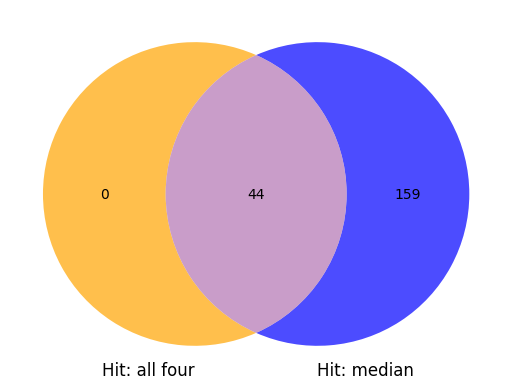

In [119]:
# depict venn diagram 
out = venn2_unweighted(subsets = (list1_uniq, list2_uniq, com), 
                 set_labels = ('Hit: all four',  
                               'Hit: median'), 
                 set_colors=("orange", 
                             "blue"),alpha=0.7) 
for text in out.set_labels:
    text.set_fontsize(14)
plt.show()

In [206]:
df_protein_var.iloc[np.where(df_protein_var["F1_Score"] > thresh_protein)].Variant.unique().size

340

In [35]:
df_non_protein_var.iloc[np.where(df_non_protein_var["F1_Score"] > thresh_nonprotein)].Variant.unique().size

192

### UMAP

In [47]:
from profiling import profiling

In [69]:
# Plot UMAP
gene_name = 'AGXT'
use_protein_feat = 'protein'
sphering = True
REG_PARAM = 1e-2

In [70]:
if use_protein_feat == 'protein':
    feature_col = feat_cols_protein
elif use_protein_feat == 'non-protein':
    feature_col = feat_cols_non_protein
else: use_protein_feat = featcol


In [71]:
gene_profiles = sc_profiles[sc_profiles['Metadata_Gene']==gene_name].reset_index(drop=True)
gene_profiles.loc[np.where(gene_profiles.Metadata_MT.isna())[0], 'Metadata_MT'] = 'Reference'

In [72]:
if sphering:
    whN = profiling.WhiteningNormalizer(gene_profiles.loc[gene_profiles["Metadata_MT"]=='Reference', 
                                                  feature_col], REG_PARAM)
    
    whD = whN.normalize(gene_profiles[feature_col])
    
    # Save whitened profiles
    gene_profiles[feature_col] = whD

(112,) (112, 112)


In [73]:
df_ref = gene_profiles[gene_profiles['Metadata_MT']=='Reference'].reset_index(drop=True)
df_var = gene_profiles[gene_profiles['Metadata_MT']!='Reference'].reset_index(drop=True)

In [74]:
# Fit on reference and transform on variants
reducer = umap.UMAP(n_neighbors=15, n_components=2)
ref_embeddings = reducer.fit_transform(df_ref[feature_col])
var_embeddings = reducer.transform(df_var[feature_col])
ref_aux = pd.concat((pd.DataFrame(ref_embeddings, columns=["X", "Y"]), df_ref.reset_index()), axis=1)
var_aux = pd.concat((pd.DataFrame(var_embeddings, columns=["X", "Y"]), df_var.reset_index()), axis=1)
aux = pd.concat([ref_aux, var_aux], axis=0, ignore_index=True)

In [75]:
ref = aux[aux['Metadata_MT']=='Reference']
var = aux[aux['Metadata_MT']!='Reference']

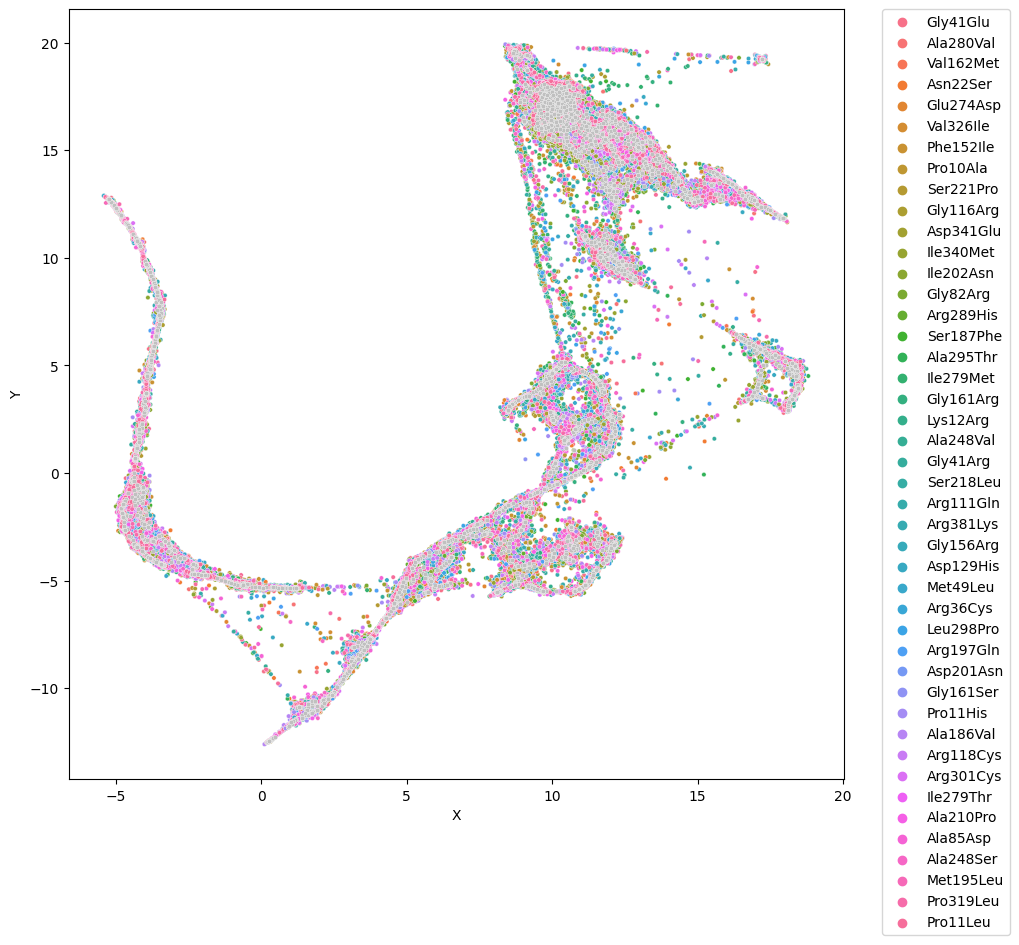

In [67]:
# UMAP of protein features - before sphering
plt.figure(figsize=(10,10))

# b = sb.scatterplot(data=neg_control, x="X", y="Y", s=5, color='red', marker='+')
# c = sb.scatterplot(data=pos_control, x="X", y="Y", s=5, color='green', marker='+')
d = sb.scatterplot(data=var, x="X", y="Y", s=10, hue="Metadata_MT")
a = sb.scatterplot(data=ref, x="X", y="Y", s=10, color='silver')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
# plt.savefig(OUTPUT_UMAP, bbox_inches='tight')


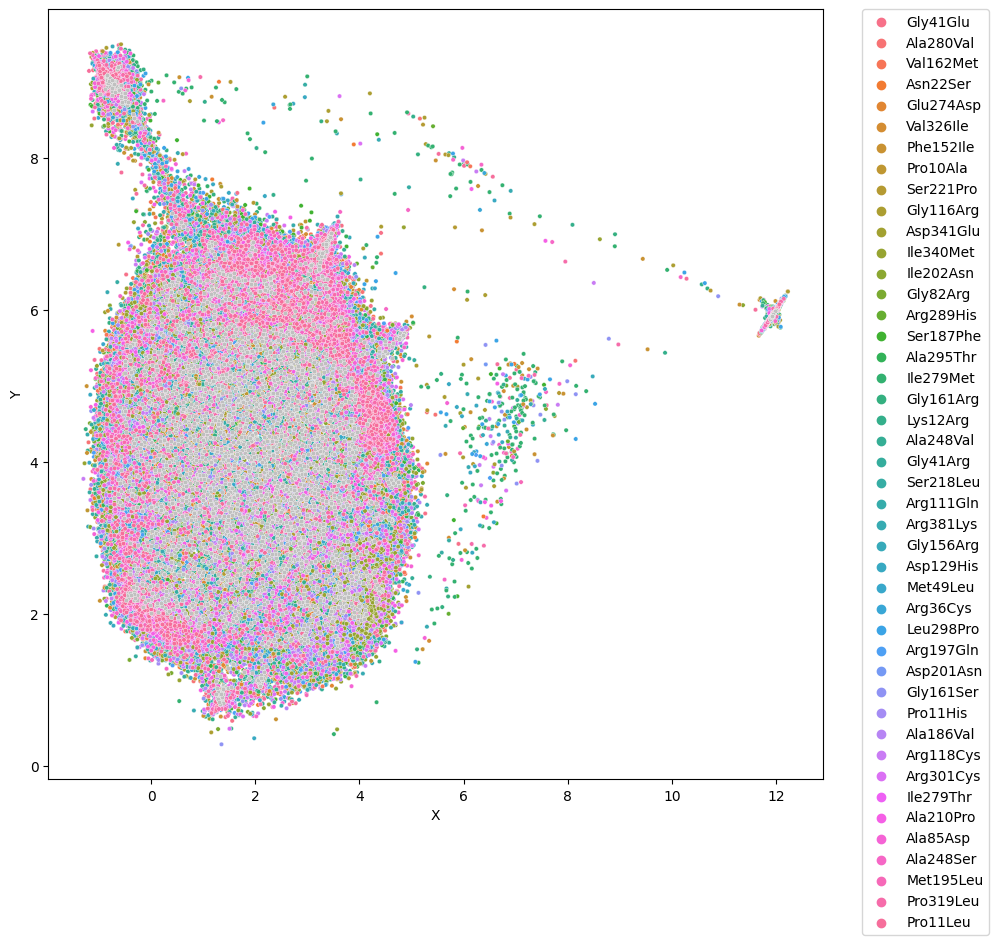

In [76]:
# UMAP of protein features - after sphering

plt.figure(figsize=(10,10))

# b = sb.scatterplot(data=neg_control, x="X", y="Y", s=5, color='red', marker='+')
# c = sb.scatterplot(data=pos_control, x="X", y="Y", s=5, color='green', marker='+')
d = sb.scatterplot(data=var, x="X", y="Y", s=10, hue="Metadata_MT")
a = sb.scatterplot(data=ref, x="X", y="Y", s=10, color='silver')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
# plt.savefig(OUTPUT_UMAP, bbox_inches='tight')


In [77]:
# Fit on both reference and variants
reducer = umap.UMAP(n_neighbors=15, n_components=2)
embeddings = reducer.fit_transform(gene_profiles[feature_col])
aux = pd.concat((pd.DataFrame(embeddings, columns=["X", "Y"]), gene_profiles.reset_index()), axis=1)

In [102]:
hit_var = df_protein_var.iloc[np.where(df_protein_var["F1_Score"] > thresh_protein)]
aux['Hit'] = aux['Metadata_Variant'].apply(lambda x: True if x in list(hit_var.Variant.unique()) else False)

In [105]:
ref = aux[aux['Metadata_MT']=='Reference']
var = aux[aux['Metadata_MT']!='Reference']
var_hit = var[var['Hit']]
var_nothit = var[~var['Hit']]

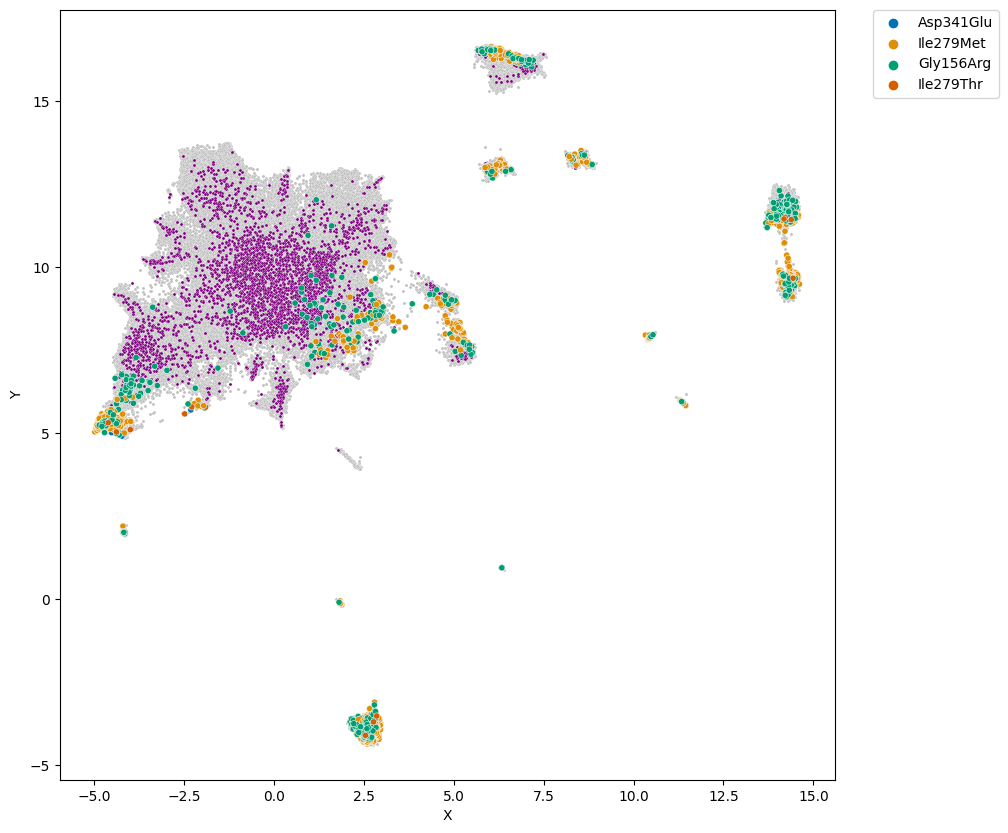

In [117]:
# UMAP of protein features - before sphering
plt.figure(figsize=(10,10))

# b = sb.scatterplot(data=neg_control, x="X", y="Y", s=5, color='red', marker='+')
# c = sb.scatterplot(data=pos_control, x="X", y="Y", s=5, color='green', marker='+')
d = sb.scatterplot(data=var_nothit, x="X", y="Y", s=5, color='silver')
a = sb.scatterplot(data=ref, x="X", y="Y", s=5, color='purple')
c = sb.scatterplot(data=var_hit, x="X", y="Y", s=20, hue='Metadata_MT', palette='colorblind')


plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
# plt.savefig(OUTPUT_UMAP, bbox_inches='tight')


In [129]:
var_hit['Plate_Well'] = var_hit['Metadata_Plate'] + '_' + var_hit['Metadata_Well']
var_hit[['Plate_Well', 'Metadata_MT']].drop_duplicates()

,Plate_Well,Metadata_MT
8353,2023-05-30_B1A1R1_P1T1_C17,Asp341Glu
13416,2023-05-30_B1A1R1_P1T1_G09,Ile279Met
21668,2023-05-30_B1A1R1_P1T1_I19,Gly156Arg
31688,2023-05-30_B1A1R1_P1T1_O07,Ile279Thr
46111,2023-05-25_B1A1R1_P1T3_C17,Asp341Glu
51253,2023-05-25_B1A1R1_P1T3_G09,Ile279Met
61257,2023-05-25_B1A1R1_P1T3_I19,Gly156Arg
71513,2023-05-25_B1A1R1_P1T3_O07,Ile279Thr
86226,2023-05-25_B1A1R1_P1T4_C17,Asp341Glu
91069,2023-05-25_B1A1R1_P1T4_G09,Ile279Met


In [131]:
ref['Plate_Well'] = ref['Metadata_Plate'] + '_' + ref['Metadata_Well']
ref['Plate_Well'].drop_duplicates()

9236      2023-05-30_B1A1R1_P1T1_E07
47810     2023-05-25_B1A1R1_P1T3_E07
87161     2023-05-25_B1A1R1_P1T4_E07
119722    2023-05-24_B1A1R1_P1T2_E07
Name: Plate_Well, dtype: object

In [135]:
# var_nothit['Plate_Well'] = var_nothit['Metadata_Plate'] + '_' + var_nothit['Metadata_Well']
var_nothit[var_nothit['Metadata_MT']=='Val326Ile'][['Plate_Well', 'Metadata_MT']].drop_duplicates()

,Plate_Well,Metadata_MT
3672,2023-05-30_B1A1R1_P1T1_A19,Val326Ile
41131,2023-05-25_B1A1R1_P1T3_A19,Val326Ile
82430,2023-05-25_B1A1R1_P1T4_A19,Val326Ile
113539,2023-05-24_B1A1R1_P1T2_A19,Val326Ile


In [134]:
df_protein_var.iloc[np.where(df_protein_var["Gene"] == gene_name)]

,Gene,Variant,F1_Score,Type
16,AGXT,AGXT Ala186Val,0.745318,Allele
17,AGXT,AGXT Ala210Pro,0.903943,Allele
18,AGXT,AGXT Ala248Ser,0.757314,Allele
19,AGXT,AGXT Ala248Val,0.667333,Allele
20,AGXT,AGXT Ala280Val,0.784535,Allele
21,AGXT,AGXT Ala295Thr,0.715376,Allele
22,AGXT,AGXT Ala85Asp,0.837671,Allele
23,AGXT,AGXT Arg111Gln,0.612118,Allele
24,AGXT,AGXT Arg118Cys,0.781967,Allele
25,AGXT,AGXT Arg197Gln,0.712835,Allele


### Heatmap to inspect well location

In [352]:
df_protein_ctrl['Well1'] = df_protein_ctrl['Well_Pair'].apply(lambda x: x.split('_')[0])
df_protein_ctrl['Well2'] = df_protein_ctrl['Well_Pair'].apply(lambda x: x.split('_')[1])
df_protein_ctrl

,Treatment,Well_Pair,F1_Score,Well1,Well2
0,516 - TC,E05_E06,0.654239,E05,E06
1,516 - TC,E05_F05,0.607378,E05,F05
2,516 - TC,E05_F06,0.664515,E05,F06
3,516 - TC,E06_F05,0.580100,E06,F05
4,516 - TC,E06_F06,0.768118,E06,F06
5,516 - TC,F05_F06,0.557306,F05,F06
6,527 ALK R1275Q,I09_I10,0.730452,I09,I10
7,527 ALK R1275Q,I09_J09,0.738325,I09,J09
8,527 ALK R1275Q,I09_J10,0.780176,I09,J10
9,527 ALK R1275Q,I10_J09,0.772221,I10,J09


In [353]:
treat_groups = df_protein_ctrl.groupby('Treatment').groups

In [374]:
def plot_heatmap(X, vmin=0, vmax=1):
    sb.set(rc={"figure.figsize": (4, 2)})
    colmap = sb.diverging_palette(240, 15, s=100, l=30, as_cmap=True)
    
    ax = sb.heatmap(
        X,
        cmap=colmap,
        square=True,
        xticklabels=True,
        yticklabels=True,
        cbar_kws={"shrink": 0.30, 'location':'left'},
        vmin=vmin,
        vmax=vmax
    )
    plt.tick_params(
        axis="both",
        which="major",
        rotation=90,
        labelsize=8,
        labelbottom=False,
        bottom=False,
        top=False,
        labeltop=True,
        right=False,
        labelright=True,
        left=False,
        labelleft=False,
    )
    plt.yticks(rotation=0)
    # ax.set_aspect("equal")
    plt.show()

dict_keys(['516 - TC', '527 ALK R1275Q', '527 ALK wt', '527 MAPK9', '527 PRKACB', '527 RHEB', '527 SLIRP', 'LPAR1', 'PTK2B'])

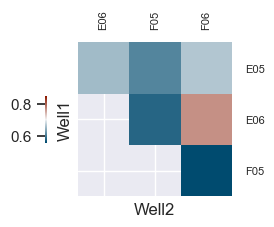

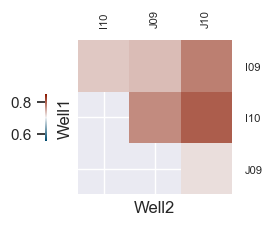

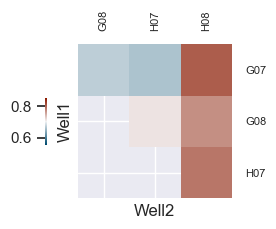

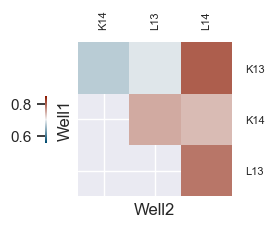

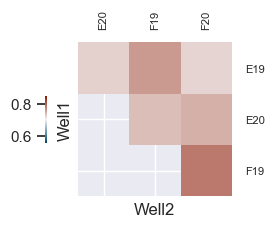

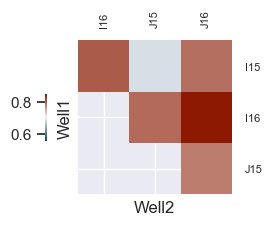

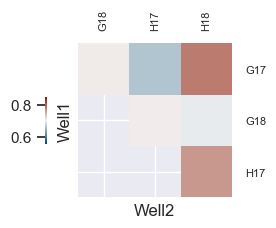

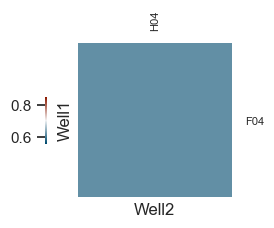

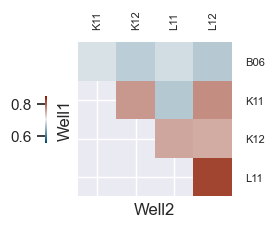

In [375]:
vmin = df_protein_ctrl['F1_Score'].min()
vmax = df_protein_ctrl['F1_Score'].max()

for treat in treat_groups.keys():
    df_treat = df_protein_ctrl.iloc[treat_groups[treat]]
    X = df_treat.pivot(
    index="Well1", columns="Well2", values="F1_Score"
    )
    plot_heatmap(X, vmin=vmin, vmax=vmax)

0.557306335012163

In [340]:
df_protein_ctrl

,Gene,Variant,F1_Score,Type,Well1,Well2
0,516 - TC,E05_E06,0.519520,Control,E05,E06
1,516 - TC,E05_F05,0.636029,Control,E05,F05
2,516 - TC,E05_F06,0.483871,Control,E05,F06
3,516 - TC,E06_F05,0.487511,Control,E06,F05
4,516 - TC,E06_F06,0.485714,Control,E06,F06
...,...,...,...,...,...,...
783,PTK2B,K11_L11,0.597125,Control,K11,L11
784,PTK2B,K11_L12,0.898516,Control,K11,L12
785,PTK2B,K12_L11,0.933714,Control,K12,L11
786,PTK2B,K12_L12,0.606081,Control,K12,L12
